# Using Python and Birdnet to Iterate Sound Analysis
### Author: Sara Joseph

## Background

### Abstract
The objective of this project was to iterate running sound analysis using BirdNET to analyze multiple folders of sound data at a time. The main external packages used are birdnetlib (and its dependencies) and pandas. I wrote three functions to facilitate this analysis. "gather_recordings" to create a list of the recordings that need to be processed. "process_recordings" to run all of the recordings through the birdnet algorithm. And finally "dataframe_recordings" to compile and organize the results from "process_recordings" into a pandas dataframe. These functions completely automate running sound analysis and produce a dataframe of results that is easy to use.

### Introduction
There are not very many free programs for analyzing sound data/recordings of bird songs and calls. The available free programs cannot handle folders with subfolders of data and there is no way to iterate the analysis. Hence, my objective was to iterate running sound analysis using BirdNET to analyze multiple folders of sound data at a time and compile the results into a single dataframe. This will make my analysis of sound data much easier and faster than any of the currently available free tools. I plan to create several functions to organize the files that need to be analyzed, run the analysis with birdnet, and compile the results into a pandas dataframe. Then, I will create some simple visualizations using pandas. 

### Study area and data
The study area is composed of six study sites in and around the city of Denton, Texas. Each study site was sample using 2 or more Wildlife Acoustics Sound Meter Micros. Sound meters were set out for one week and set to record for 5 minutes every hour. This resulted in 300+ 5 minute recordings for each study site. For the purpose of my analysis it is important that the results are for each study site, because I want to compare findings between study sites. Just to give a bit of context, I already had all of my sound files organized by site. So, I have a parent folder with a subfolder for each study site and the sound files for each study site are within the site's subfolder. Each sound file has the date saved in the file name, which is important because birdNET takes the date into account when trying to identify species. Due to time constraints and lack of computing power Ill only be analyzing 10 sound files from each study site. 

### Project design
I broke down the process of interating sound analysis into 3 steps; gathering the recording files, running the files through birdnetlib, and then creating a pandas dataframe to store the results. I wrote a function for each of these three steps. I used two external packages, pandas to help with data management and birdnetlib to analyze the sound recordings. 

BirdNET-Analyzer has been developed for automated scientific audio data processing and bird identification. BirdNet has been trained with machine learning to identify bird species based on songs and calls. The GitHub page can be found here: https://github.com/kahst/BirdNET-Analyzer

## Getting Set Up
### Installing required packages

In [5]:
#Install required packages
!pip install birdnetlib #Birdnet package
!pip install Tensorflow Lite #Birdnet dependency
!pip install ffmpeg #Birdnet dependency
!pip install librosa #Bridnet dependency
!pip install resampy #Birdnet dependency

### Import packages

In [8]:
#Import other required packages
import pandas as pd
import os
from datetime import datetime

## Creating functions
### First function - Gather and look at sound files

In [9]:
def gather_recordings(rootdir):
    """Keyword arguement is a path. The path should be to a folder containing the subfolders and files that need to be complied.
    Creates a list of files of type .wav and preserves/gathers information on the datetime, folder name, and filepath.
    Returns the file list.
    """
    fileList = [] #Initialize a list
    
    for subdir, dirs, files in os.walk(rootdir): #Iterate going through the subfolders
        count = 0
        for file in files: #Iterate going through the files
            filepath = subdir + os.sep + file #Create the filepath
            site = os.path.basename(os.path.dirname(filepath)) #Pull the site name from the subfolder
          
            if filepath.endswith(".wav"): #Select .wav files
                split_path = file.split('_') #Split the file path so we can pull out the date
                file_date = datetime.strptime(split_path[1], '%Y%m%d') #Pull the date from the split path
                fileList.append([filepath, file_date, site]) #Append the list we initialized with the file path, date, and site name
    
    return fileList #Return the file list we created

### Second function - Run recordings through BirdNET

In [3]:
def process_recordings(fileList):
    """Keyword argument is a list of sound files (.wav) with the filepath, date, and site. 
    Takes the list and iterates running each file through birdnetlib.
    Includes an except arguement to check for errors.
    Returns a list of results and a list of files that failed to run (if applicable).
    """
    from birdnetlib import Recording #Import recording class from birdnet
    from birdnetlib.analyzer import Analyzer #Import analyzer class from birdnet
    from datetime import datetime #Import function from datetime
    analyzer = Analyzer(version="2.4") #Ensure the analyzer from birdnet is up to date
    results = [] #Iniialize results list
    failed_paths = [] #Initialize list of failed file paths
    
    for path, file_date, site in fileList: #Iterate running birdnet through all the sound files
        try:
            recording = Recording( #Create recording object with the necessary info
                analyzer,
                path, #File path
                lat = 33, #Latitude
                lon = -97, #Longitude
                date = file_date, #Use the recording date we pulled earlier
                min_conf = 0.2 #Minimum confidence interval
            )

            recording.analyze() #Analyze the recording object
            results.append([[path, file_date, site], recording]) #Append the results list with the path, date, site, and recording reuslts
        except Exception as e: #Create an exception argument
            failed_paths.append(path) #Append the failed paths list with the file path if the length isnt 0
            if (len(failed_paths) != 0):
                print('AHHHH' * 15) #If the lenght isnt 0 print AHHHH so we know something went wrong
                print(e) #Print the failed paths
        
    return results, failed_paths #Return the results list and the failed paths (if applicable)

### Third Function - Create a dataframe of results

In [4]:
def dataframe_recordings(results):
    """Keyword arguement is the results object from "process_recordings". 
    Takes the results object and creates a pandas dataframe.
    """
    # Initiate dictionary w/lists (column headers)
    d = {'Site': [], 'File': [], 'Date': []}

    for (file, recording) in results: #Iterate through the files and recordings
        for detection in recording.detections: #For each bird detection append the dictionary
            d['Site'].append(file[2] if len(file) > 1 else None) #Append with the site
            d['File'].append(file[0] if len(file) > 1 else None) #Append with the file path
            d['Date'].append(file[1] if len(file) > 1 else None) #Append with the date

            for key, value in detection.items(): #for each detection 
                if key not in d: #if the values are not in the dictionary append it with the values
                    d[key] = []
                d[key].append(value)

    df = pd.DataFrame(d) #Convert the dictionary to a pandas dataframe
    return df #Return the dataframe

## Results

### Running functions

In [10]:
#First function
file_list = gather_recordings(r'YourFilePathHere') #Run the gather_recordings function and save the results to "file_list"

for file_info in file_list: #View the file_list, nicely spaced and easy to read
    print('path: ', file_info[0], '\n')
    print('date: ', file_info[1], '\n')
    print('site: ', file_info[2], '\n\n')

path:  C:\Users\saraa\OneDrive - UNT System\Doctoral Classes\Intro to Python Programming\SoundDataTrun\ClearCreek\SMM01500_20230224_090000.wav 

date:  2023-02-24 00:00:00 

site:  ClearCreek 


path:  C:\Users\saraa\OneDrive - UNT System\Doctoral Classes\Intro to Python Programming\SoundDataTrun\ClearCreek\SMM01500_20230224_100000.wav 

date:  2023-02-24 00:00:00 

site:  ClearCreek 


path:  C:\Users\saraa\OneDrive - UNT System\Doctoral Classes\Intro to Python Programming\SoundDataTrun\ClearCreek\SMM01500_20230224_110000.wav 

date:  2023-02-24 00:00:00 

site:  ClearCreek 


path:  C:\Users\saraa\OneDrive - UNT System\Doctoral Classes\Intro to Python Programming\SoundDataTrun\McKinneyRd\MRLP_20220919_100000.wav 

date:  2022-09-19 00:00:00 

site:  McKinneyRd 


path:  C:\Users\saraa\OneDrive - UNT System\Doctoral Classes\Intro to Python Programming\SoundDataTrun\McKinneyRd\MRLP_20220919_140000.wav 

date:  2022-09-19 00:00:00 

site:  McKinneyRd 


path:  C:\Users\saraa\OneDrive - 

In [42]:
#Second function
recording_results, failed_paths = process_recordings(file_list) 

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  100 chunks.
analyze_recording SMM01500_20230224_090000.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
8
97 species loaded.
read_audio_data
read_audio_data: complete, read  100 chunks.
analyze_recording SMM01500_20230224_100000.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  100 chunks.
analyze_recording SMM01500_20230224_110000.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  100 chunks.
analyze_recording MRLP_20220919_100000.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
35
89 species loaded.
read_audio_data
read_audio_data: complete, read  100 chunks.
analyze_recording MRLP_20220919_140000.wav
recording 

In [43]:
recording_results

[[['C:\\Users\\saraa\\OneDrive - UNT System\\Doctoral Classes\\Intro to Python Programming\\SoundDataTrun\\ClearCreek\\SMM01500_20230224_090000.wav',
   datetime.datetime(2023, 2, 24, 0, 0),
   'ClearCreek'],
 [['C:\\Users\\saraa\\OneDrive - UNT System\\Doctoral Classes\\Intro to Python Programming\\SoundDataTrun\\ClearCreek\\SMM01500_20230224_100000.wav',
   datetime.datetime(2023, 2, 24, 0, 0),
   'ClearCreek'],
 [['C:\\Users\\saraa\\OneDrive - UNT System\\Doctoral Classes\\Intro to Python Programming\\SoundDataTrun\\ClearCreek\\SMM01500_20230224_110000.wav',
   datetime.datetime(2023, 2, 24, 0, 0),
   'ClearCreek'],
 [['C:\\Users\\saraa\\OneDrive - UNT System\\Doctoral Classes\\Intro to Python Programming\\SoundDataTrun\\McKinneyRd\\MRLP_20220919_100000.wav',
   datetime.datetime(2022, 9, 19, 0, 0),
   'McKinneyRd'],
 [['C:\\Users\\saraa\\OneDrive - UNT System\\Doctoral Classes\\Intro to Python Programming\\SoundDataTrun\\McKinneyRd\\MRLP_20220919_140000.wav',
   datetime.datetime(2

In [44]:
#Third function
df = dataframe_recordings(recording_results)
df

,Site,File,Date,common_name,scientific_name,start_time,end_time,confidence,label
0,ClearCreek,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2023-02-24,American Crow,Corvus brachyrhynchos,36.0,39.0,0.308852,Corvus brachyrhynchos_American Crow
1,ClearCreek,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2023-02-24,American Crow,Corvus brachyrhynchos,81.0,84.0,0.721447,Corvus brachyrhynchos_American Crow
2,ClearCreek,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2023-02-24,Red-shouldered Hawk,Buteo lineatus,87.0,90.0,0.787676,Buteo lineatus_Red-shouldered Hawk
3,ClearCreek,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2023-02-24,Red-shouldered Hawk,Buteo lineatus,90.0,93.0,0.548368,Buteo lineatus_Red-shouldered Hawk
4,ClearCreek,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2023-02-24,Red-shouldered Hawk,Buteo lineatus,93.0,96.0,0.234903,Buteo lineatus_Red-shouldered Hawk
...,...,...,...,...,...,...,...,...,...
292,SouthLakes,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2022-09-24,Blue Jay,Cyanocitta cristata,159.0,162.0,0.565412,Cyanocitta cristata_Blue Jay
293,SouthLakes,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2022-09-25,American Crow,Corvus brachyrhynchos,120.0,123.0,0.407789,Corvus brachyrhynchos_American Crow
294,SouthLakes,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2022-09-25,American Crow,Corvus brachyrhynchos,150.0,153.0,0.249603,Corvus brachyrhynchos_American Crow
295,SouthLakes,C:\Users\saraa\OneDrive - UNT System\Doctoral ...,2022-09-25,American Crow,Corvus brachyrhynchos,168.0,171.0,0.209410,Corvus brachyrhynchos_American Crow


In [40]:
#Save results to csv
#df.to_csv(r"C:\Users\saraa\Desktop\SoundResults_Test2.csv", index=False)

### Species and detections per site

In [45]:
#Number recordings per site
files = pd.DataFrame(file_list, columns = ['Path', 'Date', 'Site'])
print(files)

                                                 Path       Date         Site
0   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2023-02-24   ClearCreek
1   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2023-02-24   ClearCreek
2   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2023-02-24   ClearCreek
3   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-09-19   McKinneyRd
4   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-09-19   McKinneyRd
5   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-09-19   McKinneyRd
6   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-09-22   NorthLakes
7   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-09-22   NorthLakes
8   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-09-22   NorthLakes
9   C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-10-29     OldAlton
10  C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-10-29     OldAlton
11  C:\Users\saraa\OneDrive - UNT System\Doctoral ... 2022-10-29

In [46]:
num_record = files.groupby(by = ['Site']).size().reset_index(name='NumRecord')
num_record["Time"] = num_record["NumRecord"] * 5/60
num_record

,Site,NumRecord,Time
0,ClearCreek,3,0.25
1,McKinneyRd,3,0.25
2,NorthLakes,3,0.25
3,OldAlton,3,0.25
4,ShadyShores,3,0.25
5,SouthLakes,3,0.25


In [47]:
#Detections per site
detect_site = df.groupby(by = 'Site').size().reset_index(name='NumDetect')
detect_site

,Site,NumDetect
0,ClearCreek,29
1,McKinneyRd,9
2,NorthLakes,16
3,OldAlton,65
4,ShadyShores,162
5,SouthLakes,16


In [48]:
#Number of detections of each species per site
species_detect = df.groupby(by = ['scientific_name', "common_name", "Site"]).size().reset_index(name='Count')
species_detect

,scientific_name,common_name,Site,Count
0,Baeolophus bicolor,Tufted Titmouse,McKinneyRd,1
1,Baeolophus bicolor,Tufted Titmouse,ShadyShores,45
2,Buteo lineatus,Red-shouldered Hawk,ClearCreek,15
3,Buteo lineatus,Red-shouldered Hawk,OldAlton,19
4,Cardinalis cardinalis,Northern Cardinal,ShadyShores,2
5,Chordeiles minor,Common Nighthawk,NorthLakes,7
6,Colaptes auratus,Northern Flicker,ClearCreek,2
7,Colaptes auratus,Northern Flicker,OldAlton,1
8,Corvus brachyrhynchos,American Crow,ClearCreek,6
9,Corvus brachyrhynchos,American Crow,McKinneyRd,8


In [49]:
#Number of species detected at each site
species_site = species_detect.groupby(by = ['Site']).size().reset_index(name='NumSpecies')
species_site

,Site,NumSpecies
0,ClearCreek,6
1,McKinneyRd,2
2,NorthLakes,3
3,OldAlton,4
4,ShadyShores,5
5,SouthLakes,3


In [50]:
#Merge dataframes
site_df = species_site.merge(detect_site,on='Site').merge(num_record,on='Site')
site_df

,Site,NumSpecies,NumDetect,NumRecord,Time
0,ClearCreek,6,29,3,0.25
1,McKinneyRd,2,9,3,0.25
2,NorthLakes,3,16,3,0.25
3,OldAlton,4,65,3,0.25
4,ShadyShores,5,162,3,0.25
5,SouthLakes,3,16,3,0.25


## Visualization

#### Number of detections per site

<Axes: title={'center': 'Number of Detections per Site'}, xlabel='Site', ylabel='Number of Detections'>

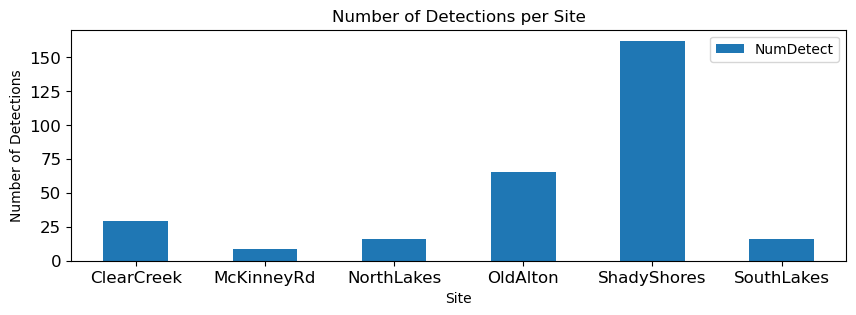

In [51]:
site_df.plot.bar(x= 'Site', y= 'NumDetect',
                     rot = 0,
                     figsize = (10,3),
                     title='Number of Detections per Site',
                     fontsize='large',
                     xlabel="Site",
                     ylabel="Number of Detections")

#### Number of detections for each species

<Axes: title={'center': 'Number of Detections per Species'}, xlabel='Species', ylabel='Number of Detections'>

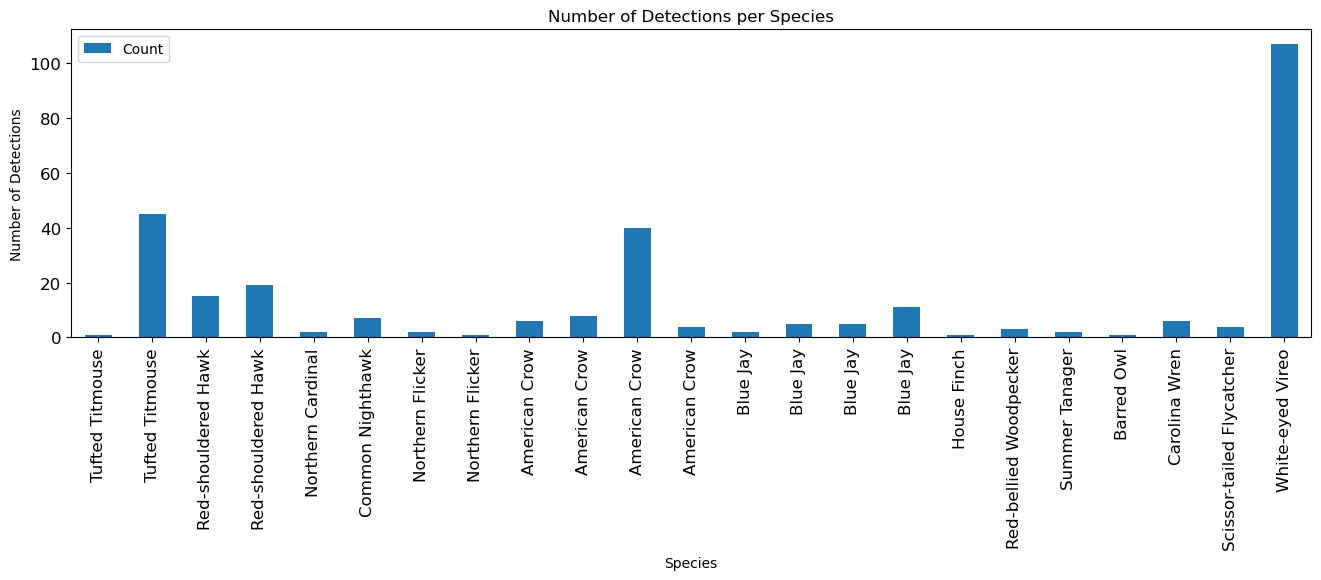

In [52]:
species_detect.plot.bar(x='common_name', y ="Count",
                     figsize = (16,4),
                     title='Number of Detections per Species',
                     fontsize='large',
                     xlabel="Species",
                     ylabel="Number of Detections")

#### Number of species per site

<Axes: title={'center': 'Number of Species per Site'}, xlabel='Site', ylabel='Number of Species'>

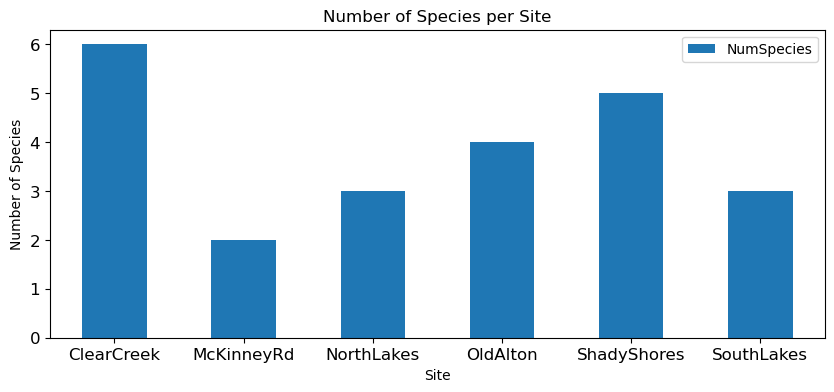

In [53]:
site_df.plot.bar(x= 'Site', y= 'NumSpecies',
                     rot = 0,
                     figsize = (10,4),
                     title='Number of Species per Site',
                     fontsize='large',
                     xlabel="Site",
                     ylabel="Number of Species")

#### Number of detections and site size

In [54]:
#Incorporating site size 
s = [['ClearCreek', 1401], ['McKinneyRd', 287], ['NorthLakes', 31], ['OldAlton', 455], ['ShadyShores', 111], ['SouthLakes', 35]]
sizedf = pd.DataFrame(data=s, columns = ['Site', 'Size_ha'])
sizedf

,Site,Size_ha
0,ClearCreek,1401
1,McKinneyRd,287
2,NorthLakes,31
3,OldAlton,455
4,ShadyShores,111
5,SouthLakes,35


In [55]:
#Combing site size into our other dataframe
sitesize_df = sizedf.merge(site_df,on='Site')
sitesize_df

,Site,Size_ha,NumSpecies,NumDetect,NumRecord,Time
0,ClearCreek,1401,6,29,3,0.25
1,McKinneyRd,287,2,9,3,0.25
2,NorthLakes,31,3,16,3,0.25
3,OldAlton,455,4,65,3,0.25
4,ShadyShores,111,5,162,3,0.25
5,SouthLakes,35,3,16,3,0.25


<Axes: title={'center': 'Number of Detections per Site Size'}, xlabel='Site Size', ylabel='Number of Detections'>

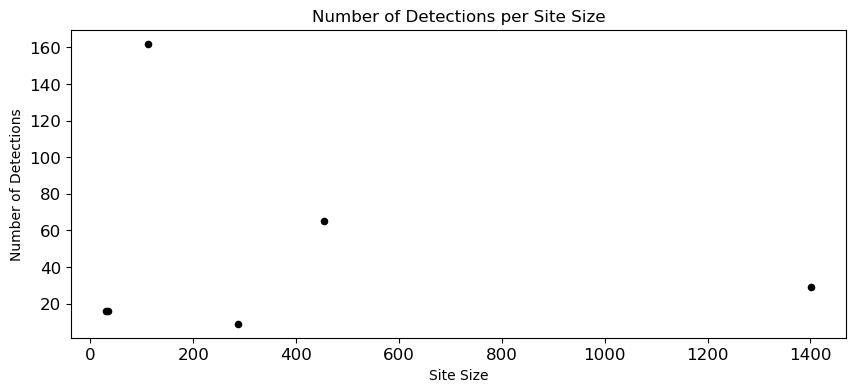

In [56]:
sitesize_df.plot.scatter("Size_ha", "NumDetect", s=None, c="black",
                     figsize = (10,4),
                     title='Number of Detections per Site Size',
                     fontsize='large',
                     xlabel="Site Size",
                     ylabel="Number of Detections")

#### Number of species and site size

<Axes: title={'center': 'Number of Species per Site Size'}, xlabel='Site Size', ylabel='Number of Species'>

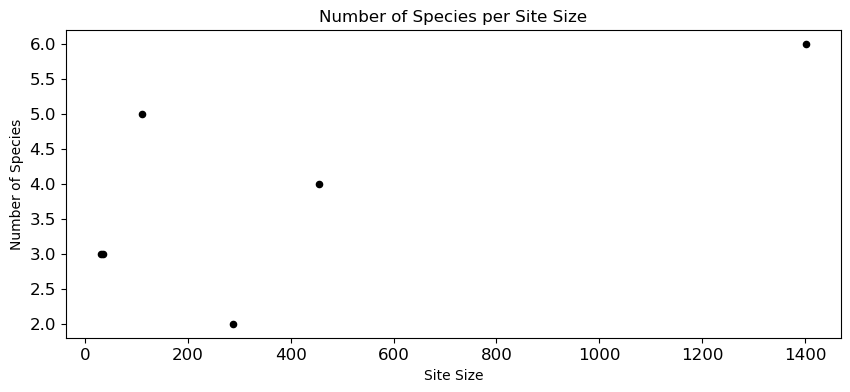

In [57]:
sitesize_df.plot.scatter("Size_ha", "NumSpecies", s=None, c="black",
                     figsize = (10,4),
                     title='Number of Species per Site Size',
                     fontsize='large',
                     xlabel="Site Size",
                     ylabel="Number of Species")

## Conclusion
Because Ive written this code specifically for my analysis, I was able to keep my files organized by study site and pull the date of the file from the file name so I dont have to enter it by hand. Little things like that end up taking a lot of time when there is a lot of data to process! In total, I wrote three functions that compiled my results into a pandas dataframe containg a row for each bird detection with information on the site, date, file path, species detected (common and scientific name), start time, end time, and confidence. Ill be collecting this data for the next two years so Ill have a lot of use for this code!

In the future, Id like to turn this code into a module and clean it up some. Id also like to create my own species list for birdnetlib to use instead of relying on the species list generated within the package. 

## Citations

Kahl, S., Wood, C. M., Eibl, M. and Klinck, H. 2021. BirdNET: A deep learning solution for avian diversity monitoring. Ecological Informatics 61:101236.